In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, multilabel_confusion_matrix, classification_report99
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


# Import data

In [ ]:
link1= 'http://promise.site.uottawa.ca/SERepository/datasets/cm1.arff'
link2 = 'http://promise.site.uottawa.ca/SERepository/datasets/jm1.arff'
link3 = 'http://promise.site.uottawa.ca/SERepository/datasets/kc1.arff'
link4 = 'http://promise.site.uottawa.ca/SERepository/datasets/kc2.arff'
link5 = 'http://promise.site.uottawa.ca/SERepository/datasets/pc1.arff'
links = [link5]

In [ ]:
from urllib.request import urlopen
from scipy.io import arff
import pandas as pd
import chardet
import urllib.request
import scipy.io.arff

# with urlopen(arff_url) as f:
#     encoding = chardet.detect(f.read())['encoding']


In [ ]:
import tempfile
df = pd.DataFrame()
for link in links:
  with tempfile.NamedTemporaryFile() as temp:
      with urlopen(link) as f:
          temp.write(f.read())
          temp.flush()
      data, meta = arff.loadarff(temp.name)
      data = pd.DataFrame(data)
      data.rename(columns={ 'iv(G)':'iv(g)', 'N':'n', 'V':'v', 'L':'l', 'D':'d', 'I':'i', 'E':'e','B':'b', 'T':'t'},inplace = True)
      df = pd.concat([df,data])

In [ ]:
df.shape

(1109, 22)

In [ ]:
df.isna().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
locCodeAndComment    0
lOBlank              0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [ ]:
# df.drop(['lOCodeAndComment','problems','locCodeAndComment'],axis =1, inplace=True)

In [ ]:
#df.drop(['lOCodeAndComment','problems','v','total_Op','total_Opnd','b','t','l','v(g)','locCodeAndComment','lOCode','ev(g)','lOComment','i'],axis= 1,inplace = True)
df.dropna(inplace= True)
df.drop(['v','total_Op','total_Opnd','b','t','l','v(g)','locCodeAndComment','lOCode','ev(g)','lOComment','i'],axis= 1,inplace = True)

In [ ]:
df

,loc,iv(g),n,d,e,lOBlank,uniq_Op,uniq_Opnd,branchCount,defects
0,1.1,1.4,1.3,1.30,1.30,2.0,1.2,1.2,1.4,b'false'
1,1.0,1.0,1.0,1.00,1.00,1.0,1.0,1.0,1.0,b'true'
2,91.0,2.0,318.0,27.68,57833.24,31.0,29.0,66.0,17.0,b'true'
3,109.0,18.0,381.0,28.37,72282.68,24.0,28.0,75.0,38.0,b'true'
4,505.0,82.0,2339.0,75.93,1571506.88,49.0,64.0,397.0,178.0,b'true'
...,...,...,...,...,...,...,...,...,...,...
1104,6.0,1.0,26.0,13.33,1282.82,2.0,10.0,3.0,7.0,b'false'
1105,10.0,1.0,43.0,21.00,3835.88,1.0,14.0,5.0,9.0,b'false'
1106,5.0,1.0,17.0,4.80,301.96,0.0,8.0,5.0,5.0,b'false'
1107,18.0,5.0,111.0,22.92,14050.56,1.0,22.0,24.0,15.0,b'false'


In [ ]:
df.defects.value_counts()

defects
b'false'    1032
b'true'       77
Name: count, dtype: int64

In [ ]:
def encode_label(row):
  row = str(row)
  if 'false' in row:
    return 0
  else:
    return 1

In [ ]:
df.defects = df.defects.apply(lambda x : encode_label(x))

In [ ]:
df.defects.value_counts()

defects
0    1032
1      77
Name: count, dtype: int64

In [ ]:
df.dtypes

loc            float64
iv(g)          float64
n              float64
d              float64
e              float64
lOBlank        float64
uniq_Op        float64
uniq_Opnd      float64
branchCount    float64
defects          int64
dtype: object

  1. loc             : numeric % McCabe's line count of code
  2. v(g)            : numeric % McCabe "cyclomatic complexity"
  3. ev(g)           : numeric % McCabe "essential complexity"
  4. iv(g)           : numeric % McCabe "design complexity"
  5. n               : numeric % Halstead total operators + operands
  6. v               : numeric % Halstead "volume"
  7. l               : numeric % Halstead "program length"
  8. d               : numeric % Halstead "difficulty"
  9. i               : numeric % Halstead "intelligence"
  10. e               : numeric % Halstead "effort"
  11. b               : numeric % Halstead
  12. t               : numeric % Halstead's time estimator
  13. lOCode          : numeric % Halstead's line count
  14. lOComment       : numeric % Halstead's count of lines of comments
  15. lOBlank         : numeric % Halstead's count of blank lines
  17. uniq_Op         : numeric % unique operators
  18. uniq_Opnd       : numeric % unique operands
  19. total_Op        : numeric % total operators
  20. total_Opnd      : numeric % total operands
  21: branchCount     : numeric % of the flow graph
  22. defects         : {false,true} % module has/has not one or more
%                                        % reported defects

## co-relation

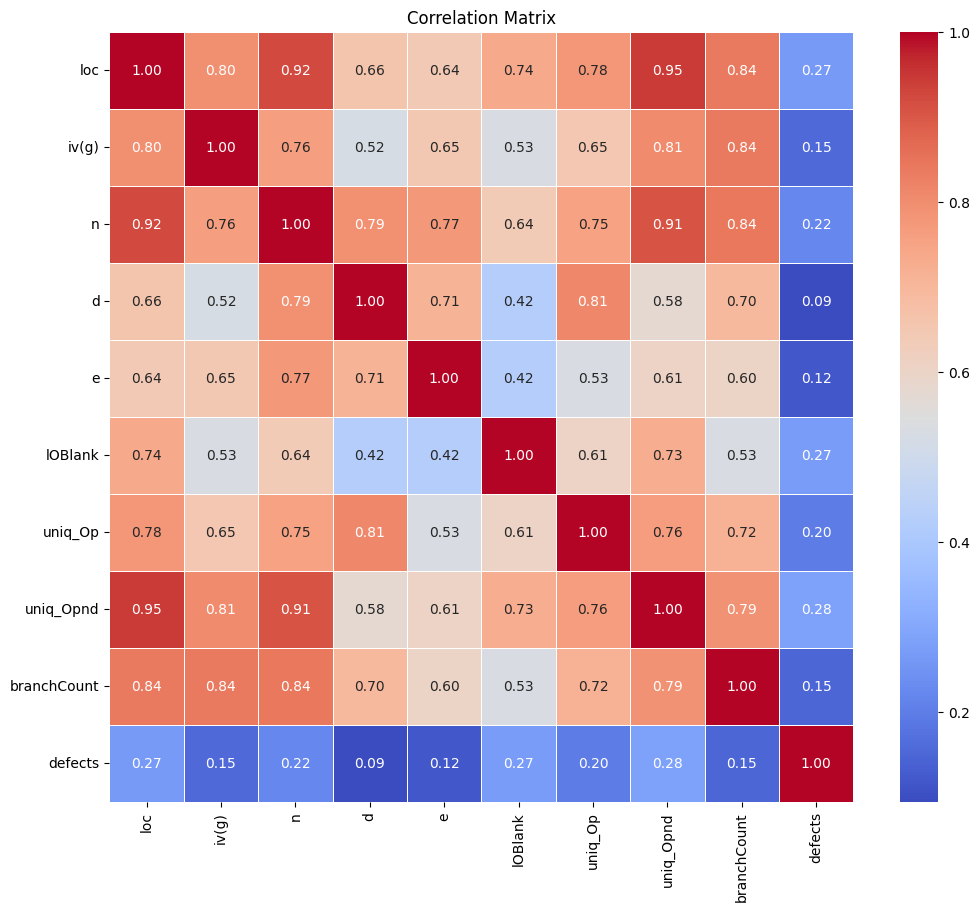

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
# If you don't have a correlation matrix, you can create one using the corr() method
correlation_matrix = df.corr()

# Plotting a heatmap for better visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


1. Cyclomatic complexity is a measurement developed by Thomas McCabe to determine the stability and level of confidence in a program. It measures the number of linearly-independent paths through a program module. Programs with lower Cyclomatic complexity are easier to understand and less risky to modify.

2. Essential complexity is a measurement developed by Thomas McCabe to determine how well a program is structured. It measures the number of entry points, termination points, and nondeductible nodes. The closer to 1 this value is, the more well structured the program is.

3. Module design complexity, iv, is a measurement of the decision structure of a module, G, which controls the invocation of G's immediate subordinate modules.

4. Program length (N): This is the total number of operator and operand occurrences in the program.


5. Vocabulary size (n): This is the total number of distinct operators and operands in the program.


6. Program volume (V): This is the product of program length (N) and the logarithm of vocabulary size (n), i.e., V = N*log2(n).

7. Program level (L): This is the ratio of the number of operator occurrences to the number of operand occurrences in the program, i.e., L = n1/n2, where n1 is the number of operator occurrences and n2 is the number of operand occurrences.


8. Program difficulty (D): This is the ratio of the number of unique operators to the total number of operators in the program, i.e., D = (n1/2) * (N2/n2).


9. Program effort (E): This is the product of program volume (V) and program difficulty (D), i.e., E = V*D.


10. Time to implement (T): This is the estimated time required to implement the program, based on the program effort (E) and a constant value that depends on the programming language and development environment.

In [ ]:
df['defects'].value_counts()

defects
0    1032
1      77
Name: count, dtype: int64

In [ ]:
df.dtypes

loc            float64
iv(g)          float64
n              float64
d              float64
e              float64
lOBlank        float64
uniq_Op        float64
uniq_Opnd      float64
branchCount    float64
defects          int64
dtype: object

In [ ]:
df.shape

(1109, 10)

In [ ]:
X = df.drop(['defects'],axis = 1)
y = df['defects']

In [ ]:
X.shape

(1109, 9)

In [ ]:
y.shape

(1109,)

In [ ]:
columns = X.columns

In [ ]:
columns = columns.to_list()

In [ ]:
columns

['loc',
 'iv(g)',
 'n',
 'd',
 'e',
 'lOBlank',
 'uniq_Op',
 'uniq_Opnd',
 'branchCount']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

## distribution check

In [ ]:
def ploting(df , cols, ax):
  # Generate a list of 14 random colors
  colors = ['#' + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(11)]

  # Plot KDE plots for each column with a unique random color
  # fig, ax = plt.subplots(figsize=(10, 6))
  for i, column in enumerate(cols):
      sns.kdeplot(df[column], ax=ax, color=colors[i])

  # plt.show()  # Show the plot






In [ ]:
import pandas as pd
from scipy.stats import boxcox

# Assuming df is your DataFrame

# Function to apply Box-Cox transformation to each column
def boxcox_transform(column):
    # Check if any values are negative
    if (column <= 0).any():
        # Shift the data to make it positive
        column_shifted = column - column.min() + 1e-6  # Adding a small value to avoid zero
        transformed_column, _ = boxcox(column_shifted)
    else:
        transformed_column, _ = boxcox(column)
    return transformed_column

In [ ]:
# ploting(X, columns)

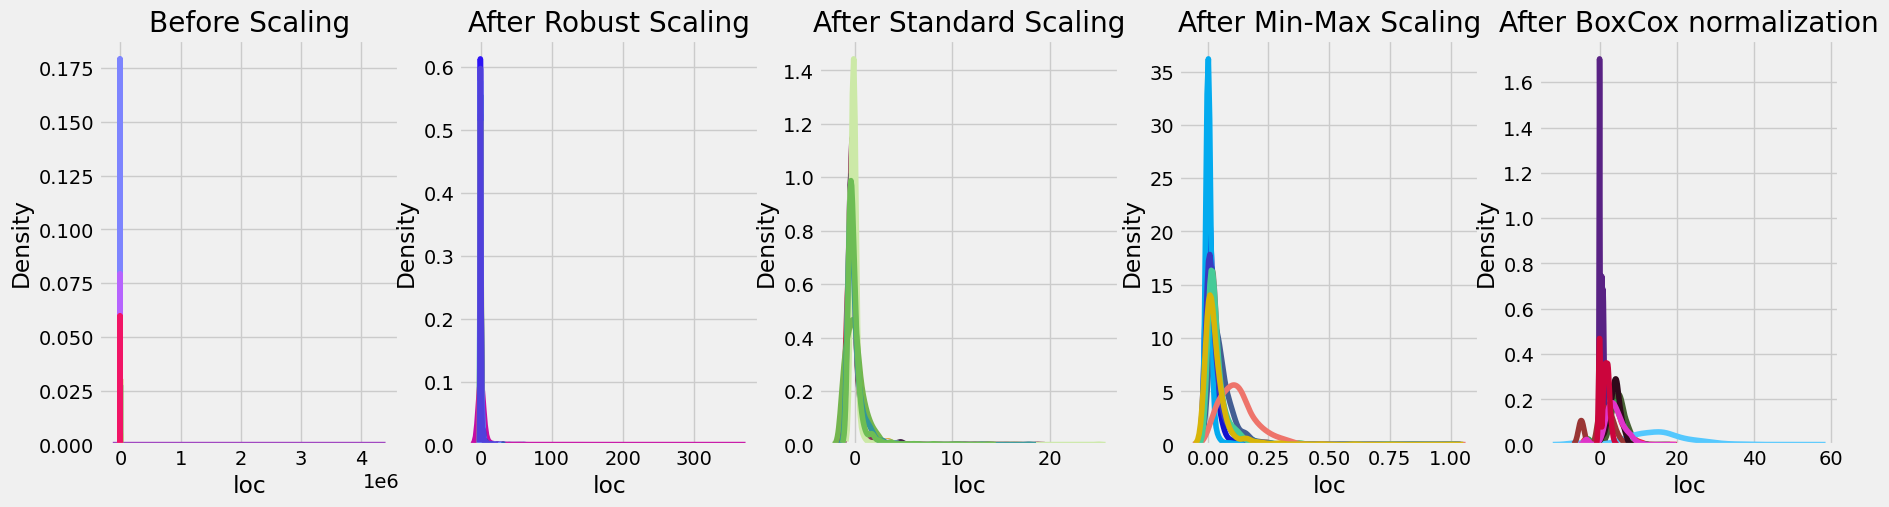

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# for Box-Cox Transformation
from scipy import stats
# % matplotlib inline
matplotlib.style.use('fivethirtyeight')

np.random.normal

scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(X)
robust_df = pd.DataFrame(robust_df, columns =columns)

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(X)
standard_df = pd.DataFrame(standard_df, columns =columns)

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(X)
minmax_df = pd.DataFrame(minmax_df, columns =columns)

# Apply Box-Cox transformation to each column of the DataFrame
boxcox_df = X.apply(boxcox_transform)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols = 5, figsize =(20, 5))
ax1.set_title('Before Scaling')
ploting(X, cols=columns, ax = ax1)
ax2.set_title('After Robust Scaling')
ploting(robust_df, columns, ax=ax2)
ax3.set_title('After Standard Scaling')
ploting(standard_df, columns, ax=ax3)
ax4.set_title('After Min-Max Scaling')
ploting(minmax_df, columns, ax = ax4)
ax5.set_title('After BoxCox normalization')
ploting(boxcox_df, columns, ax = ax5)
# sns.kdeplot(minmax_df['x1'], ax = ax4, color ='black')
# sns.kdeplot(minmax_df['x2'], ax = ax4, color ='g')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold,train_test_split

X_train, X_test, y_train, y_test = train_test_split(boxcox_df, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)


In [ ]:
X_train.shape

(887, 9)

In [ ]:
X_test.shape

(222, 9)

## sampling dataset
(eg. Smote, random over sampling, random under sampling)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Assume X_train and y_train are your features and labels for training data

# SMOTE
smote = SMOTE()
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

# Random Oversampling
ros = RandomOverSampler()
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)

# Random Undersampling
rus = RandomUnderSampler()
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)


In [ ]:
y.value_counts()

defects
0    1032
1      77
Name: count, dtype: int64

In [ ]:
y_train.value_counts()

defects
0    825
1     62
Name: count, dtype: int64

In [ ]:
y_resampled_smote.value_counts()

defects
0    825
1    825
Name: count, dtype: int64

In [ ]:
y_resampled_ros.value_counts()

defects
0    825
1    825
Name: count, dtype: int64

In [ ]:
y_resampled_rus.value_counts()

defects
0    62
1    62
Name: count, dtype: int64

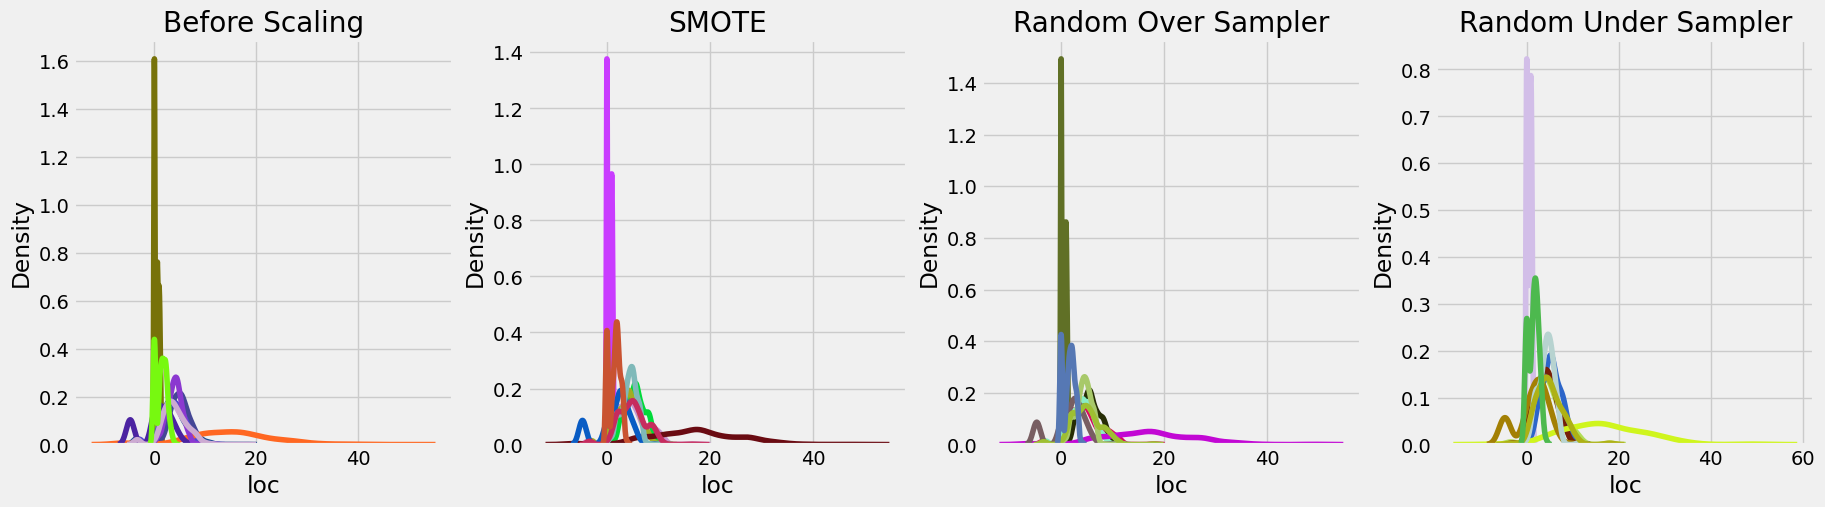

In [ ]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')
ploting(X_train, cols=columns, ax = ax1)
ax2.set_title('SMOTE')
ploting(X_resampled_smote, columns, ax=ax2)
ax3.set_title('Random Over Sampler')
ploting(X_resampled_ros, columns, ax=ax3)
ax4.set_title('Random Under Sampler')
ploting(X_resampled_rus, columns, ax = ax4)
# sns.kdeplot(minmax_df['x1'], ax = ax4, color ='black')
# sns.kdeplot(minmax_df['x2'], ax = ax4, color ='g')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model building

### Decision Tree

In [ ]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train==False:
        '''
        test performance
        '''
        print("Test Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))


In [ ]:
clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_resampled_smote, y_resampled_smote)

print_score(clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=True)

print_score(clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=False) # Test

Train Result:

accuracy score: 0.9976

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       825
           1       1.00      1.00      1.00       825

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650


Confusion Matrix: 
 [[825   0]
 [  4 821]]

Average Accuracy: 	 0.9309
Accuracy SD: 		 0.0267
Test Result:

accuracy score: 0.8829

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       207
           1       0.26      0.40      0.32        15

    accuracy                           0.88       222
   macro avg       0.61      0.66      0.63       222
weighted avg       0.91      0.88      0.89       222


Confusion Matrix: 
 [[190  17]
 [  9   6]]



Our decision tree has an accuracy 0.76

### Bagging (obb_score = False)

In [ ]:
bag_clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                            bootstrap=True, n_jobs=-1,
                            random_state=42)

bag_clf.fit(X_resampled_smote, y_resampled_smote)

print_score(bag_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=True)

print_score(bag_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=False)

Train Result:

accuracy score: 0.9976

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       825
           1       1.00      1.00      1.00       825

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650


Confusion Matrix: 
 [[823   2]
 [  2 823]]

Average Accuracy: 	 0.9521
Accuracy SD: 		 0.0187
Test Result:

accuracy score: 0.8964

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       207
           1       0.32      0.47      0.38        15

    accuracy                           0.90       222
   macro avg       0.64      0.70      0.66       222
weighted avg       0.92      0.90      0.91       222


Confusion Matrix: 
 [[192  15]
 [  8   7]]



### Bagging (obb_score = True)

In [ ]:
bag_clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                            bootstrap=True, oob_score=True,
                            n_jobs=-1, random_state=42)
bag_clf.fit(X_resampled_smote, y_resampled_smote)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=1000, n_jobs=-1, oob_score=True,
                  random_state=42)

In [ ]:
bag_clf.oob_score_

0.9563636363636364

In [ ]:
print_score(bag_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=True)

Train Result:

accuracy score: 0.9976

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       825
           1       1.00      1.00      1.00       825

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650


Confusion Matrix: 
 [[823   2]
 [  2 823]]

Average Accuracy: 	 0.9521
Accuracy SD: 		 0.0187


In [ ]:
print_score(bag_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=False)

Test Result:

accuracy score: 0.8964

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       207
           1       0.32      0.47      0.38        15

    accuracy                           0.90       222
   macro avg       0.64      0.70      0.66       222
weighted avg       0.92      0.90      0.91       222


Confusion Matrix: 
 [[192  15]
 [  8   7]]



### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train==False:
        '''
        test performance
        '''
        print("Test Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))

In [ ]:
rf_clf = RandomForestClassifier(random_state=42)

In [ ]:
rf_clf.fit(X_resampled_smote, y_resampled_smote)

RandomForestClassifier(random_state=42)

In [ ]:
print_score(rf_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=True)

Train Result:

accuracy score: 0.9976

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       825
           1       1.00      1.00      1.00       825

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650


Confusion Matrix: 
 [[823   2]
 [  2 823]]

Average Accuracy: 	 0.9533
Accuracy SD: 		 0.0153


In [ ]:
print_score(rf_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=False)

Test Result:

accuracy score: 0.9144

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       207
           1       0.40      0.53      0.46        15

    accuracy                           0.91       222
   macro avg       0.68      0.74      0.71       222
weighted avg       0.93      0.91      0.92       222


Confusion Matrix: 
 [[195  12]
 [  7   8]]



### Grid Search

In [ ]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

In [ ]:
rf_clf = RandomForestClassifier(random_state=42)

In [ ]:
params_grid = {"max_depth": [3, None],
               "min_samples_split": [2, 3, 10],
               "min_samples_leaf": [1, 3, 10],
               "bootstrap": [True, False],
               "criterion": ['gini', 'entropy']}

In [ ]:
grid_search = GridSearchCV(rf_clf, params_grid,
                           n_jobs=-1, cv=5,
                           verbose=1, scoring='accuracy')

In [ ]:
grid_search.fit(X_resampled_smote, y_resampled_smote)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, None], 'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10]},
             scoring='accuracy', verbose=1)

In [ ]:
grid_search.best_score_

0.9563636363636364

In [ ]:
grid_search.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
print_score(grid_search, X_resampled_smote, y_resampled_smote, X_test, y_test, train=True)

Train Result:

accuracy score: 0.9976

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       825
           1       1.00      1.00      1.00       825

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650


Confusion Matrix: 
 [[825   0]
 [  4 821]]

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fittin

In [ ]:
print_score(grid_search, X_resampled_smote, y_resampled_smote, X_test, y_test, train=False)

Test Result:

accuracy score: 0.9189

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       207
           1       0.41      0.47      0.44        15

    accuracy                           0.92       222
   macro avg       0.69      0.71      0.70       222
weighted avg       0.92      0.92      0.92       222


Confusion Matrix: 
 [[197  10]
 [  8   7]]



### Extra tree

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
xt_clf = ExtraTreesClassifier(random_state=42)

xt_clf.fit(X_resampled_smote, y_resampled_smote)

print_score(xt_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=True)

print_score(xt_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=False)

Train Result:

accuracy score: 0.9976

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       825
           1       1.00      1.00      1.00       825

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650


Confusion Matrix: 
 [[825   0]
 [  4 821]]

Average Accuracy: 	 0.9739
Accuracy SD: 		 0.0082
Test Result:

accuracy score: 0.9234

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       207
           1       0.44      0.53      0.48        15

    accuracy                           0.92       222
   macro avg       0.71      0.74      0.72       222
weighted avg       0.93      0.92      0.93       222


Confusion Matrix: 
 [[197  10]
 [  7   8]]



### Ada boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier()

ada_clf.fit(X_resampled_smote, y_resampled_smote)

print_score(ada_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=True)

print_score(ada_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=False)

Train Result:

accuracy score: 0.9048

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.86      0.90       825
           1       0.87      0.95      0.91       825

    accuracy                           0.90      1650
   macro avg       0.91      0.90      0.90      1650
weighted avg       0.91      0.90      0.90      1650


Confusion Matrix: 
 [[713 112]
 [ 45 780]]

Average Accuracy: 	 0.8830
Accuracy SD: 		 0.0372
Test Result:

accuracy score: 0.7883

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.80      0.88       207
           1       0.18      0.60      0.28        15

    accuracy                           0.79       222
   macro avg       0.57      0.70      0.58       222
weighted avg       0.91      0.79      0.84       222


Confusion Matrix: 
 [[166  41]
 [  6   9]]



# AdaBoost with Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
ada_clf = AdaBoostClassifier(RandomForestClassifier())

ada_clf.fit(X_resampled_smote, y_resampled_smote)

print_score(ada_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=True)

print_score(ada_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=False)

ada_clf = AdaBoostClassifier(base_estimator=RandomForestClassifier())

ada_clf.fit(X_resampled_smote, y_resampled_smote)

print_score(ada_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=True)

print_score(ada_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=False)

Train Result:

accuracy score: 0.9976

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       825
           1       1.00      1.00      1.00       825

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650


Confusion Matrix: 
 [[822   3]
 [  1 824]]

Average Accuracy: 	 0.9576
Accuracy SD: 		 0.0160
Test Result:

accuracy score: 0.9054

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       207
           1       0.36      0.53      0.43        15

    accuracy                           0.91       222
   macro avg       0.66      0.73      0.69       222
weighted avg       0.92      0.91      0.91       222


Confusion Matrix: 
 [[193  14]
 [  7   8]]

Train Result:

accuracy score: 0.9976

Classification Report: 
               p

### Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc_clf = GradientBoostingClassifier()
gbc_clf.fit(X_resampled_smote, y_resampled_smote)

GradientBoostingClassifier()

In [ ]:
print_score(gbc_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=True)

Train Result:

accuracy score: 0.9685

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       825
           1       0.96      0.98      0.97       825

    accuracy                           0.97      1650
   macro avg       0.97      0.97      0.97      1650
weighted avg       0.97      0.97      0.97      1650


Confusion Matrix: 
 [[791  34]
 [ 18 807]]

Average Accuracy: 	 0.9242
Accuracy SD: 		 0.0365


In [ ]:
print_score(gbc_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=False)

Test Result:

accuracy score: 0.8739

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       207
           1       0.26      0.47      0.33        15

    accuracy                           0.87       222
   macro avg       0.61      0.69      0.63       222
weighted avg       0.91      0.87      0.89       222


Confusion Matrix: 
 [[187  20]
 [  8   7]]



### XG Boost

In [ ]:
import xgboost as xgb

In [ ]:
xgb_clf = xgb.XGBClassifier(max_depth=5, n_estimators=10000, learning_rate=0.3,
                            n_jobs=-1)

In [ ]:
xgb_clf.fit(X_resampled_smote, y_resampled_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
print_score(xgb_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=True)

Train Result:

accuracy score: 0.9976

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       825
           1       1.00      1.00      1.00       825

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650


Confusion Matrix: 
 [[823   2]
 [  2 823]]

Average Accuracy: 	 0.9533
Accuracy SD: 		 0.0317


In [ ]:
print_score(xgb_clf, X_resampled_smote, y_resampled_smote, X_test, y_test, train=False)

Test Result:

accuracy score: 0.9144

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       207
           1       0.39      0.47      0.42        15

    accuracy                           0.91       222
   macro avg       0.67      0.71      0.69       222
weighted avg       0.92      0.91      0.92       222


Confusion Matrix: 
 [[196  11]
 [  8   7]]

